In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import pyspark.ml.feature 
spark = SparkSession.builder.appName('Iteration_4').getOrCreate()

In [2]:
from pyspark.sql.functions import isnan, when, count, col, avg
from pyspark.ml.regression import LinearRegression, RandomForestRegressor

In [3]:
import statistics 
import numpy

In [4]:
# Import data
df1 = spark.read.csv('Housing_Data_1_encoded .csv', inferSchema=True, header=True)
df2 = spark.read.csv('Housing_Data_2_encoded.csv', inferSchema=True, header=True)

In [5]:
# Merge data 
data = df1.union(df2)

In [6]:
def convert_pandas (data):
    return data.toPandas() 

def convert_spark (data):
    return spark.createDataFrame(data)

# 2.3 Exploration

In [7]:
print("Rows: ", data.count(), "Columns: ", len(data.columns))

Rows:  34857 Columns:  21


In [8]:
data.head()

Row(Suburb='Abbotsford', Address='68 Studley St', Rooms=2, Type='h', Price=None, Method='SS', SellerG='Jellis', Date='3/09/2016', Distance='2.5', Postcode='3067', Bedroom2=2, Bathroom=1, Car=1, Landsize=126, BuildingArea=None, YearBuilt=None, CouncilArea='Yarra City Council', Lattitude=-37.8014, Longtitude=144.9958, Regionname='Northern Metropolitan', Propertycount='4019')

In [9]:
data.printSchema() 

root
 |-- Suburb: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Method: string (nullable = true)
 |-- SellerG: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Bedroom2: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: integer (nullable = true)
 |-- BuildingArea: double (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- CouncilArea: string (nullable = true)
 |-- Lattitude: double (nullable = true)
 |-- Longtitude: double (nullable = true)
 |-- Regionname: string (nullable = true)
 |-- Propertycount: string (nullable = true)



In [10]:
data.describe()

DataFrame[summary: string, Suburb: string, Address: string, Rooms: string, Type: string, Price: string, Method: string, SellerG: string, Date: string, Distance: string, Postcode: string, Bedroom2: string, Bathroom: string, Car: string, Landsize: string, BuildingArea: string, YearBuilt: string, CouncilArea: string, Lattitude: string, Longtitude: string, Regionname: string, Propertycount: string]

# Data Quality

In [11]:
import pandas as pd

In [12]:
data = convert_pandas(data)

In [13]:
def get_completeness (data): 
    
    print('\n Completeness \n')
    
    for column in data.columns:
        percent = (len(data) - data[column].isnull().sum()) / len(data)
    
        print(column, ': ', round(percent * 100, 2), '%')

In [14]:
# Counts of null values in the data. 
print(data.isnull().sum())

get_completeness(data)

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             0
Postcode             0
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          0
Lattitude         7976
Longtitude        7976
Regionname           0
Propertycount        0
dtype: int64

 Completeness 

Suburb :  100.0 %
Address :  100.0 %
Rooms :  100.0 %
Type :  100.0 %
Price :  78.17 %
Method :  100.0 %
SellerG :  100.0 %
Date :  100.0 %
Distance :  100.0 %
Postcode :  100.0 %
Bedroom2 :  76.43 %
Bathroom :  76.4 %
Car :  74.96 %
Landsize :  66.12 %
BuildingArea :  39.42 %
YearBuilt :  44.61 %
CouncilArea :  100.0 %
Lattitude :  77.12 %
Longtitude :  77.12 %
Regionname :  100.0 %
Propertycount :  100.0 %


In [15]:
data.describe()

,Rooms,Price,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude
count,34857.000000,2.724700e+04,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000
mean,3.031012,1.050173e+06,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851
std,0.969933,6.414671e+05,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169
min,1.000000,8.500000e+04,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790
25%,2.000000,6.350000e+05,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500
50%,3.000000,8.700000e+05,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800
75%,4.000000,1.295000e+06,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900
max,16.000000,1.120000e+07,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350


In [16]:
data.var()

Rooms           9.407699e-01
Price           4.114801e+11
Bedroom2        9.617523e-01
Bathroom        5.244830e-01
Car             1.021658e+00
Landsize        1.155213e+07
BuildingArea    1.610153e+05
YearBuilt       1.393393e+03
Lattitude       8.150281e-03
Longtitude      1.444053e-02
dtype: float64

In [17]:
# back to spark 
data = convert_spark(data)

# 3.1 Data Selection

In [18]:
print('Columns: ', len(data.columns))

columns_to_drop = ['Address', 'Date', 'Method', 'Postcode', 'SellerG']
data = data.select([column for column in data.columns if column not in columns_to_drop])

print('Columns: ', len(data.columns))

Columns:  21
Columns:  16


# 3.2 Data Cleaning

In [19]:
# Removing Null values for price

data = data.na.drop(subset='Price')
print(data.count())

27247


In [20]:
# Remove columns with too many missing values. ITERATION**********

data = data.drop('YearBuilt', 'BuildingArea')

print("columns: ", len(data.columns))

columns:  14


In [21]:
# Imputing Missing Numeric Values

data = convert_pandas(data)

# Selecting numeric and categorical data
numeric_data = data._get_numeric_data()

non_numeric = data.drop(data._get_numeric_data(), axis=1)
print(numeric_data.head())
column_headers = numeric_data.columns

   Rooms      Price  Bedroom2  Bathroom  Car  Landsize  Lattitude  Longtitude
0      2  1480000.0       2.0       1.0  1.0     202.0   -37.7996    144.9984
1      2  1035000.0       2.0       1.0  0.0     156.0   -37.8079    144.9934
2      3  1465000.0       3.0       2.0  0.0     134.0   -37.8093    144.9944
3      3   850000.0       3.0       2.0  1.0      94.0   -37.7969    144.9969
4      4  1600000.0       3.0       1.0  2.0     120.0   -37.8072    144.9941


In [22]:
import statistics
import math

In [23]:
for column in numeric_data:
    mean = data[column].mean()
    median = data[column].median()
    
    data[column].fillna(mean, inplace=True)

In [24]:
get_completeness(data)


 Completeness 

Suburb :  100.0 %
Rooms :  100.0 %
Type :  100.0 %
Price :  100.0 %
Distance :  100.0 %
Bedroom2 :  100.0 %
Bathroom :  100.0 %
Car :  100.0 %
Landsize :  100.0 %
CouncilArea :  100.0 %
Lattitude :  100.0 %
Longtitude :  100.0 %
Regionname :  100.0 %
Propertycount :  100.0 %


In [25]:
data.shape

(27247, 14)

In [26]:
# Iteration ***********************

# Removing Outliers

for col in numeric_data:
    mean = data[col].mean()
#     Change for iteration 
    cut_off = data[col].std() * 3
    high = mean + cut_off
    low = mean - cut_off
    data = data[(data[col]<high) & (data[col]>low)]

print(data.shape)

(25409, 14)


# 3.3 Data Construction 

In [27]:
# 467, 512, 8970 - quantiles for each 1/3 of data

values = []

for x in data['Landsize']:
    value = ''
    if x <= 467:
        value = 'S'
    elif (x > 467) & (x <= 512):
        value = 'M'
    elif x > 512:
        value = 'L'
    values.append(value)
 
data['Landsize'] = values 
print(data.head())

       Suburb  Rooms Type      Price Distance  Bedroom2  Bathroom  Car  \
0  Abbotsford      2    h  1480000.0      2.5       2.0       1.0  1.0   
1  Abbotsford      2    h  1035000.0      2.5       2.0       1.0  0.0   
2  Abbotsford      3    h  1465000.0      2.5       3.0       2.0  0.0   
3  Abbotsford      3    h   850000.0      2.5       3.0       2.0  1.0   
4  Abbotsford      4    h  1600000.0      2.5       3.0       1.0  2.0   

  Landsize         CouncilArea  Lattitude  Longtitude             Regionname  \
0        S  Yarra City Council   -37.7996    144.9984  Northern Metropolitan   
1        S  Yarra City Council   -37.8079    144.9934  Northern Metropolitan   
2        S  Yarra City Council   -37.8093    144.9944  Northern Metropolitan   
3        S  Yarra City Council   -37.7969    144.9969  Northern Metropolitan   
4        S  Yarra City Council   -37.8072    144.9941  Northern Metropolitan   

  Propertycount  
0          4019  
1          4019  
2          4019  
3 

# 3.4 Data Merge

Conduted previously at the start of the note book.

# 3.5 Data Reformatting

In [28]:
from pyspark.ml.feature import StringIndexer

In [29]:
data = convert_spark(data)

In [30]:
# Encoding categorical data

cat_columns = ['Type', 'Propertycount','Suburb', 'Landsize', 'CouncilArea', 'Regionname']

for col in cat_columns:
    new_name = col + '_2'
    indexer = StringIndexer (inputCol=col, outputCol=new_name)
    data = indexer.fit(data).transform(data)

data = data.select([column for column in data.columns if column not in cat_columns])

data.show()

+-----+---------+--------+------------------+------------------+------------------+-------------------+------------------+------+---------------+--------+----------+-------------+------------+
|Rooms|    Price|Distance|          Bedroom2|          Bathroom|               Car|          Lattitude|        Longtitude|Type_2|Propertycount_2|Suburb_2|Landsize_2|CouncilArea_2|Regionname_2|
+-----+---------+--------+------------------+------------------+------------------+-------------------+------------------+------+---------------+--------+----------+-------------+------------+
|    2|1480000.0|     2.5|               2.0|               1.0|               1.0|           -37.7996|          144.9984|   0.0|           84.0|    85.0|       1.0|         13.0|         1.0|
|    2|1035000.0|     2.5|               2.0|               1.0|               0.0|           -37.8079|          144.9934|   0.0|           84.0|    85.0|       1.0|         13.0|         1.0|
|    3|1465000.0|     2.5|         

In [31]:
data.dtypes

[('Rooms', 'bigint'),
 ('Price', 'double'),
 ('Distance', 'string'),
 ('Bedroom2', 'double'),
 ('Bathroom', 'double'),
 ('Car', 'double'),
 ('Lattitude', 'double'),
 ('Longtitude', 'double'),
 ('Type_2', 'double'),
 ('Propertycount_2', 'double'),
 ('Suburb_2', 'double'),
 ('Landsize_2', 'double'),
 ('CouncilArea_2', 'double'),
 ('Regionname_2', 'double')]

In [32]:
# Convert Distance to a numeric type

data = data.withColumn("Distance", data.Distance.cast('double'))

In [33]:
# Bug where a single null was getting through, so removed it.  
data = data.dropna() 

# 4.1 Data Reduction

In [34]:
data = convert_pandas(data)
data.corr() 

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Type_2,Propertycount_2,Suburb_2,Landsize_2,CouncilArea_2,Regionname_2
Rooms,1.000000,0.482461,0.325439,0.826696,0.487883,0.339163,0.052016,0.088677,-0.356456,0.148712,0.151979,-0.177304,0.119958,0.187110
Price,0.482461,1.000000,-0.186682,0.387000,0.321207,0.167364,-0.256884,0.192111,-0.302269,-0.115941,-0.119110,-0.042857,-0.107896,-0.193081
Distance,0.325439,-0.186682,1.000000,0.284914,0.156874,0.238820,0.035269,0.241496,-0.153649,0.480360,0.482740,-0.262690,0.487236,0.462245
Bedroom2,0.826696,0.387000,0.284914,1.000000,0.574252,0.405966,0.054126,0.105086,-0.271569,0.134169,0.137088,-0.282811,0.109236,0.166892
Bathroom,0.487883,0.321207,0.156874,0.574252,1.000000,0.302148,-0.033448,0.102633,-0.017110,0.087472,0.089342,-0.111485,0.088010,0.056792
Car,0.339163,0.167364,0.238820,0.405966,0.302148,1.000000,0.010387,0.066473,-0.128671,0.080178,0.082929,-0.272025,0.063686,0.092827
Lattitude,0.052016,-0.256884,0.035269,0.054126,-0.033448,0.010387,1.000000,-0.322008,-0.106520,-0.045110,-0.043778,0.005715,-0.191589,0.098835
Longtitude,0.088677,0.192111,0.241496,0.105086,0.102633,0.066473,-0.322008,1.000000,-0.006642,0.128370,0.132439,-0.136951,0.169627,0.093558
Type_2,-0.356456,-0.302269,-0.153649,-0.271569,-0.017110,-0.128671,-0.106520,-0.006642,1.000000,-0.113889,-0.115708,0.071604,-0.097860,-0.143931
Propertycount_2,0.148712,-0.115941,0.480360,0.134169,0.087472,0.080178,-0.045110,0.128370,-0.113889,1.000000,0.991844,-0.150497,0.503852,0.441718


In [35]:
# ITERATION*****************************

to_remove = ['Car', 'Landsize_2', 'Propertycount_2', 'CouncilArea_2', 'Regionname_2', 'Suburb_2']

# Removing columns from both data sets
data_pruned = data.drop(to_remove, axis=1)

# 4.2 Statistical Transformation 

(array([  12.,  281., 1166., 2284., 3209., 3293., 2815., 2273., 1751.,
        1475., 1500., 1130.,  811.,  709.,  553.,  580.,  359.,  215.,
         235.,  197.,  150.,  112.,  117.,  108.,   73.]),
 array([  85000.,  199200.,  313400.,  427600.,  541800.,  656000.,
         770200.,  884400.,  998600., 1112800., 1227000., 1341200.,
        1455400., 1569600., 1683800., 1798000., 1912200., 2026400.,
        2140600., 2254800., 2369000., 2483200., 2597400., 2711600.,
        2825800., 2940000.]),
 <a list of 25 Patch objects>)

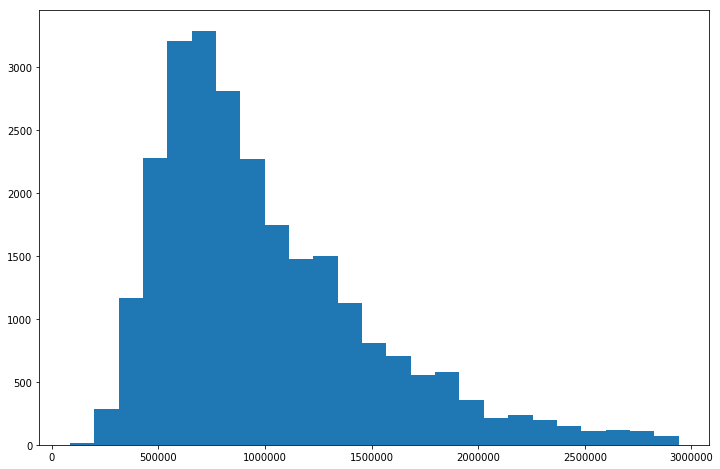

In [36]:
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline

plt.figure(figsize=(12,8))
plt.hist(data_pruned['Price'], bins=25)

{'boxes': [<matplotlib.lines.Line2D at 0x7fac88ea8cc0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fac88eb2710>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fac88eb93c8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fac88eb2f60>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fac88ea8e10>,
  <matplotlib.lines.Line2D at 0x7fac88eb22e8>]}

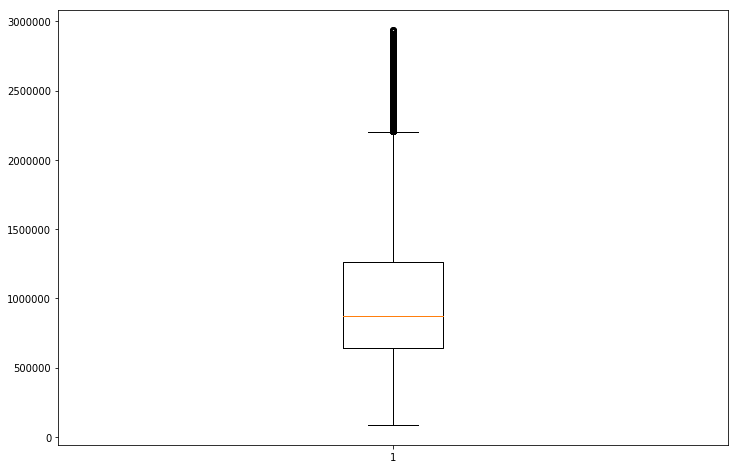

In [37]:
plt.figure(figsize=(12,8))
plt.boxplot(data_pruned['Price'])

In [38]:
log_data = data_pruned.copy()
log_data['Price'] = np.log10(log_data['Price'])

(array([1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        1.700e+01, 5.500e+01, 1.550e+02, 3.270e+02, 5.610e+02, 9.750e+02,
        1.510e+03, 2.123e+03, 2.858e+03, 2.998e+03, 2.836e+03, 2.271e+03,
        2.257e+03, 2.111e+03, 1.565e+03, 1.241e+03, 6.990e+02, 5.130e+02,
        3.240e+02]),
 array([4.92941893, 4.99097606, 5.0525332 , 5.11409033, 5.17564747,
        5.23720461, 5.29876174, 5.36031888, 5.42187602, 5.48343315,
        5.54499029, 5.60654742, 5.66810456, 5.7296617 , 5.79121883,
        5.85277597, 5.9143331 , 5.97589024, 6.03744738, 6.09900451,
        6.16056165, 6.22211879, 6.28367592, 6.34523306, 6.40679019,
        6.46834733]),
 <a list of 25 Patch objects>)

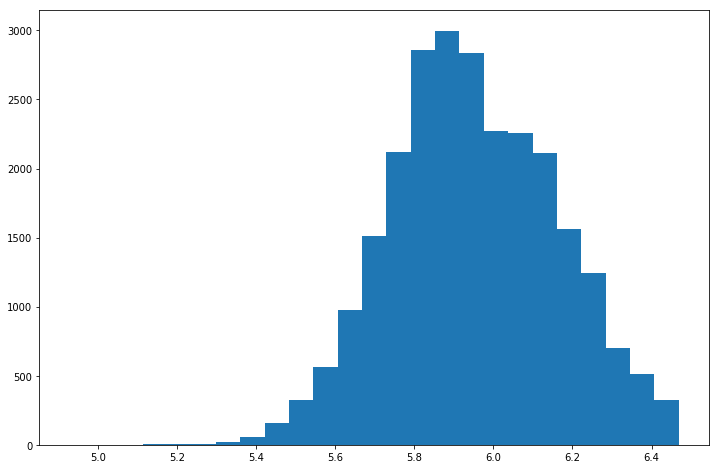

In [39]:
plt.figure(figsize=(12,8))
plt.hist(log_data['Price'], bins=25)

# 6.1 Algorithm Exploration 

In [40]:
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [41]:
# Depending on what data you want to proceed using - makes it less cluttered

df = log_data.copy()
# df = data_pruned

df = convert_spark(df)
data_pruned = convert_spark(data_pruned)
log_data = convert_spark(log_data)

In [42]:
# Getting data into appropriate format for ML using VECTORS

input_columns = df.drop('Price').columns
print(input_columns)

assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
output = assembler.transform(df)
output.head(1)

ml_data = output.select('features', 'Price')

['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Lattitude', 'Longtitude', 'Type_2']


In [43]:
output.head(1)

[Row(Rooms=2, Price=6.1702617153949575, Distance=2.5, Bedroom2=2.0, Bathroom=1.0, Lattitude=-37.7996, Longtitude=144.9984, Type_2=0.0, features=DenseVector([2.0, 2.5, 2.0, 1.0, -37.7996, 144.9984, 0.0]))]

In [44]:
ml_data.show() 

+--------------------+------------------+
|            features|             Price|
+--------------------+------------------+
|[2.0,2.5,2.0,1.0,...|6.1702617153949575|
|[2.0,2.5,2.0,1.0,...| 6.014940349792937|
|[3.0,2.5,3.0,2.0,...| 6.165837624690128|
|[3.0,2.5,3.0,2.0,...| 5.929418925714293|
|[4.0,2.5,3.0,1.0,...| 6.204119982655925|
|[2.0,2.5,2.0,1.0,...| 5.973589623427257|
|[3.0,2.5,4.0,2.0,...| 6.273232834043045|
|[2.0,2.5,2.0,1.0,...| 6.213783299335304|
|[3.0,2.5,3.046236...|               6.0|
|[2.0,2.5,3.046236...| 5.872156272748293|
|[1.0,2.5,1.0,1.0,...| 5.477121254719663|
|[2.0,2.5,3.0,1.0,...| 6.040206627574711|
|[2.0,2.5,3.046236...| 5.733999286538387|
|[2.0,2.5,3.046236...| 5.880813592280791|
|[1.0,2.5,3.046236...| 5.682145076373832|
|[2.0,2.5,2.0,2.0,...| 5.845098040014257|
|[3.0,2.5,3.0,2.0,...|6.1303337684950066|
|[2.0,2.5,2.0,2.0,...|   5.8750612633917|
|[4.0,2.5,3.046236...| 6.297760511099134|
|[1.0,2.5,3.046236...| 5.698970004336019|
+--------------------+------------

In [45]:
def get_accuracy (results, test):
    
    predictions = convert_pandas(results.predictions)['prediction']
    
    test_set = convert_pandas(test.select('Price'))['Price']
    
    index = 0
    differences = []
    diff_percent = []
    y = list(test_set)

    for prediction in predictions:
        diff = (  abs((10**prediction) - (10**y[index]))  )
        differences.append(diff)

        percent = (diff/10**y[index]) * 100
        diff_percent.append(percent)
        index += 1

    print('mean difference', statistics.mean(differences))
    print('mean difference percentage', statistics.mean(diff_percent))
    return [differences, diff_percent]

In [46]:
# UNCOMMENT FOR ITERATION

# def get_accuracy (results, test):
    
#     predictions = convert_pandas(results.predictions)['prediction']
    
#     test_set = convert_pandas(test.select('Price'))['Price']
    
#     index = 0
#     differences = []
#     diff_percent = []
#     y = list(test_set)

#     for prediction in predictions:
#         diff = abs(prediction - y[index])
#         differences.append(diff)
    
#         percent = (diff/y[index]) * 100
#         diff_percent.append(percent)
#         index += 1
        
#     print('mean difference', statistics.mean(differences))
#     print('mean difference percentage', statistics.mean(diff_percent))
#     return [differences, diff_percent]

In [47]:
# Creating train/test splits to test models. 

train_data, test_data = ml_data.randomSplit([0.95,0.05], seed=5)

In [48]:
# Create models

lasso = LinearRegression(labelCol='Price', predictionCol='prediction', elasticNetParam=1)
ridge = LinearRegression(labelCol='Price', predictionCol='prediction', elasticNetParam=0)
linear = LinearRegression(labelCol='Price', predictionCol='prediction')
SGD = LinearRegression(labelCol='Price', predictionCol='prediction', solver='gd')


In [49]:
# Fit the models

las_model = lasso.fit(train_data)
ridge_model = ridge.fit(train_data)
lr_model = linear.fit(train_data)
SGD_model = SGD.fit(train_data)


In [50]:
# Evaluate models on test data

las_results = las_model.evaluate(test_data)
ridge_results = ridge_model.evaluate(test_data)
lr_results = lr_model.evaluate(test_data)
SGD_results = SGD_model.evaluate(test_data)


In [51]:
# Outcomes
print('Lasso:')
x =get_accuracy(las_results, test_data)
print("r2: {}".format(las_results.r2))
print("RMSE: {}".format(las_results.rootMeanSquaredError), '\n')

print('Ridge:')
y = get_accuracy(ridge_results, test_data)
print("r2: {}".format(ridge_results.r2))
print("RMSE: {}".format(ridge_results.rootMeanSquaredError), '\n')

print('Linear:')
z = get_accuracy(lr_results, test_data)
print("r2: {}".format(lr_results.r2))
print("RMSE: {}".format(lr_results.rootMeanSquaredError), '\n')

print('SGD:')
z = get_accuracy(SGD_results, test_data)
print("r2: {}".format(SGD_results.r2))
print("RMSE: {}".format(SGD_results.rootMeanSquaredError), '\n')


Lasso:
mean difference 250513.67780710265
mean difference percentage 26.031334759086967
r2: 0.5513070766328295
RMSE: 0.13946686234058267 

Ridge:
mean difference 250513.67780710265
mean difference percentage 26.031334759086967
r2: 0.5513070766328295
RMSE: 0.13946686234058267 

Linear:
mean difference 250513.67780710265
mean difference percentage 26.031334759086967
r2: 0.5513070766328295
RMSE: 0.13946686234058267 

SGD:
mean difference 250513.67250111222
mean difference percentage 26.03133474236153
r2: 0.5513070758896024
RMSE: 0.13946686245609102 



# 6.3 Parameter Selection

In [52]:
def cv_splits (data):
    cv1, cv2, cv3, cv4, cv5, cv6, cv7, cv8, cv9, cv10 = ml_data.randomSplit([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
    return [cv1, cv2, cv3, cv4, cv5, cv6, cv7, cv8, cv9, cv10]

In [53]:
# UNCOMMENT CODE TO FIND OPTIMAL PARAMETER
# regParam

# best_param = 0
# error = 100000

# for i in range(1,100):
#     lr = LinearRegression(labelCol='Price', predictionCol='prediction', elasticNetParam=0, regParam=i)
#     model = linear.fit(train_data)
#     results = model.evaluate(test_data)
#     if results.rootMeanSquaredError < error:
#         error = results.rootMeanSquaredError
#         best_param = i

# print(best_param)
# print(error)

In [54]:
# UNCOMMENT CODE TO FIND OPTIMAL PARAMETER
# elasticNetParam 

# net = 0
# error = 100000

# for i in list(numpy.linspace(0, 1, num=50)):
#     lr = LinearRegression(labelCol='Price', predictionCol='prediction', elasticNetParam=i)
#     model = linear.fit(train_data)
#     results = model.evaluate(test_data)
#     if results.rootMeanSquaredError < error:
#         error = results.rootMeanSquaredError
#         net = i
        
# print(net)
# print(error)

In [55]:
# UNCOMMENT CODE TO FIND OPTIMAL PARAMETER
# fit intercept

# for i in [True, False]:
#     lr = LinearRegression(labelCol='Price', predictionCol='prediction', elasticNetParam=0, fitIntercept=i)
#     model = lr.fit(train_data)
#     results = model.evaluate(test_data)
#     print('Intercept: ', i)
#     print('Error: ', results.rootMeanSquaredError)

# 7.2 Run Model

In [56]:
# Final model 

lr = LinearRegression(labelCol='Price', predictionCol='prediction', elasticNetParam=0, regParam=0, fitIntercept=True)
model = lr.fit(train_data)
results = model.evaluate(test_data)

# 7.3 Patterns and Outputs 

In [57]:
def get_stats (diff):
    
    diff = np.array(diff)
    
    print('Mean:', diff.mean())
    print('Standard Deviation: ', diff.std())
    print('Min: ', diff.min())
    print('Max: ', diff.max(), '\n')

In [58]:
# Accuracy
differences, diff_percent = get_accuracy(results, test_data)

# Root Mean Squared Error
print("RMSE: {}".format(results.rootMeanSquaredError), '\n')

# Coefficients & Intercept 
print("Coefficients: {} Intercept: {}".format(model.coefficients, model.intercept), '\n')

# R-Squared
print("R2: {}".format(results.r2), '\n')

print('Absolute Differences')
get_stats(differences)
print('Percentage Differences')
get_stats(diff_percent)

mean difference 250513.67780710265
mean difference percentage 26.031334759086967
RMSE: 0.13946686234058267 

Coefficients: [0.14606528397632731,-0.014991645257961593,-0.02908356027388674,0.041064984617047995,-0.654864671804895,0.4101105755800107,-0.06611184543773979] Intercept: -78.48344418442483 

R2: 0.5513070766328295 

Absolute Differences
Mean: 250513.67780710262
Standard Deviation:  247068.19620906195
Min:  74.9846762958914
Max:  1687138.0083347324 

Percentage Differences
Mean: 26.031334759086967
Standard Deviation:  22.189608983894196
Min:  0.009994758516726826
Max:  273.6745258153362 



# 8.2 Visualise the Results

In [59]:
import matplotlib.pyplot as plt

In [60]:
list(model.coefficients)

[0.14606528397632731,
 -0.014991645257961593,
 -0.02908356027388674,
 0.041064984617047995,
 -0.654864671804895,
 0.4101105755800107,
 -0.06611184543773979]

In [61]:
coef_dict = {}
for coef, feature in zip(list(model.coefficients), input_columns):
    coef_dict[feature] = coef
    
print(coef_dict)

{'Bedroom2': -0.02908356027388674, 'Type_2': -0.06611184543773979, 'Longtitude': 0.4101105755800107, 'Distance': -0.014991645257961593, 'Lattitude': -0.654864671804895, 'Rooms': 0.14606528397632731, 'Bathroom': 0.041064984617047995}


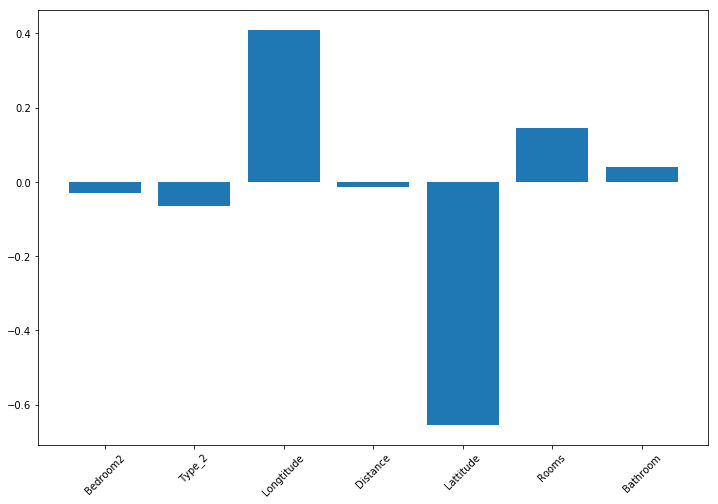

In [62]:
plt.figure(figsize=(12,8))
plt.bar(*zip(*coef_dict.items()))
plt.xticks(rotation=45)
plt.show()

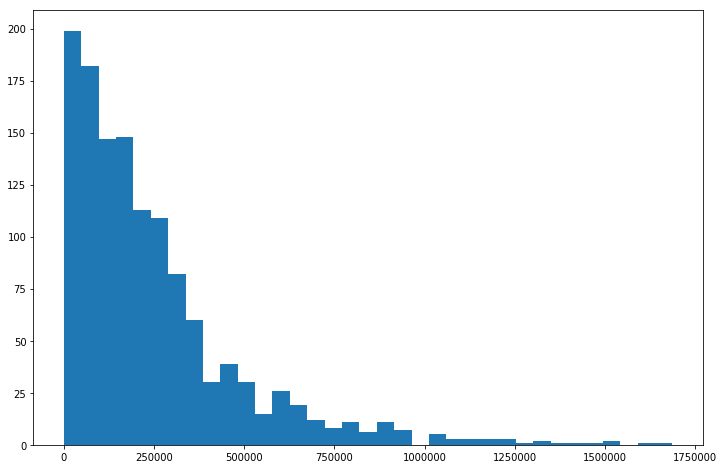

In [63]:
plt.figure(figsize=(12,8))
plt.hist(differences, bins=35)
plt.show()

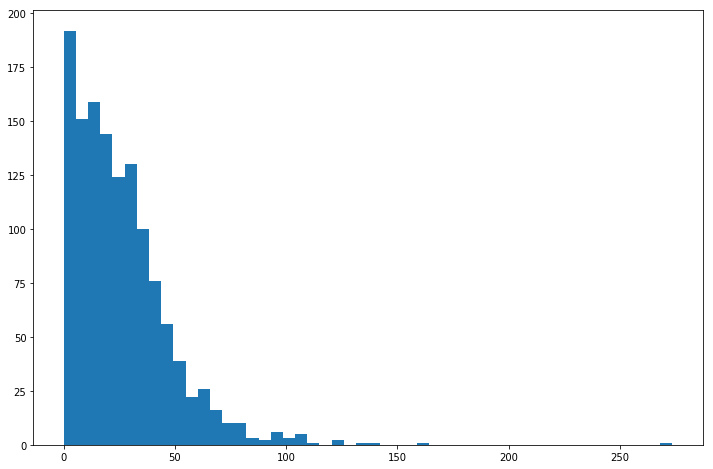

In [64]:
plt.figure(figsize=(12,8))
plt.hist(diff_percent, bins=50)
plt.show()

In [65]:
predictions = convert_pandas(results.predictions)['prediction']
    
actual = convert_pandas(test_data.select('Price'))['Price']

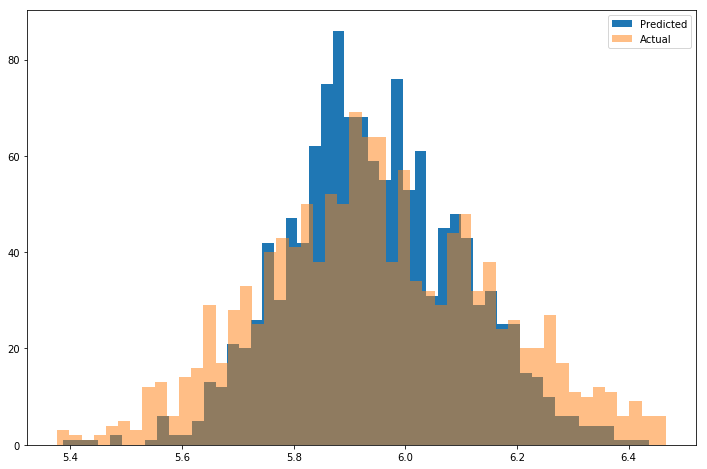

In [66]:
plt.figure(figsize=(12,8))
plt.hist(predictions, bins=50, alpha=1, label='Predicted')
plt.hist(actual, bins=50, alpha=0.5, label='Actual')
plt.legend(loc='upper right')
plt.show()